In [6]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gymnasium as gym


import time
import os
env = gym.make('highway-v0', render_mode='rgb_array')

from IPython.display import clear_output

import matplotlib.pyplot as plt

NameNotFound: Environment `highway` doesn't exist.

# Setting up the DQN Class and Agent

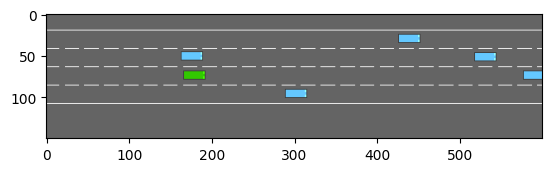

action 1


AttributeError: 'NoneType' object has no attribute 'get_image'

In [7]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

# create instance of replay buffer
#replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
    
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)# AJOUT
        return self.net(x)
    

class DQN: # Marche mais mauvais résultats
    def __init__(self,
                env,# AJOUT
                action_space,
                observation_space,
                gamma,
                batch_size,
                buffer_capacity,
                update_target_every, 
                epsilon_start, 
                decrease_epsilon_factor, 
                epsilon_min,
                learning_rate,
                ): 
        
        self.env = env # AJOUT

        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        
        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every
        
        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = decrease_epsilon_factor # larger -> more exploration
        self.epsilon_min = epsilon_min
        
        self.learning_rate = learning_rate
        
        self.reset()
        
    def get_action(self, state, epsilon=None):
        """
            ** Solution ** 
        
            Return action according to an epsilon-greedy exploration policy
        """
        if epsilon is None: 
            epsilon = self.epsilon
            
        if np.random.rand() < epsilon: 
            action = env.action_space.sample()
            #print(f"np.random.rand() < epsilon"," choix de l'action :",action)
            return action
        else: 
            #print("else")
            #print("np.argmax(self.get_q(state))",np.argmax(self.get_q(state)))

            #q = self.get_q(state)

            #print("Q :",self.get_q(state))
            #print("argmax Q",np.argmax(self.get_q(state)))

            #index_max_sum = np.argmax(np.sum(q, axis=1))

            # Sélectionner la ligne correspondante dans le tableau q
            #selected_action = np.argmax(q[index_max_sum])

            #print("selected_action",selected_action)

            #return selected_action
            return np.argmax(self.get_q(state))


            # Sinon, retourner l'action maximisant la valeur Q prédite
            # q_values = self.get_q(state)
            # print("q_values",q_values)
            # # Assurez-vous que les actions valides restent dans les limites de l'espace d'actions
            # valid_actions = np.arange(self.action_space.n)
            # print("valid_action",valid_actions)
            # print("np.argmax(q_values[valid_actions])",np.argmax(q_values[valid_actions]))
            # return np.argmax(q_values[valid_actions])
    
    def update(self, state, action, reward, terminated, next_state):
        #print("UPDATE")

        # AJOUT
        # Convert numpy arrays or lists to tensors and ensure they are floats
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        action_tensor = torch.tensor([[action]], dtype=torch.int64)
        reward_tensor = torch.tensor([reward], dtype=torch.float32)
        terminated_tensor = torch.tensor([terminated], dtype=torch.float32)

        # Store transition in the replay buffer
        self.buffer.push(
            state_tensor,
            action_tensor,
            reward_tensor,
            terminated_tensor,
            next_state_tensor,
        )
        # FIN AJOUT

        # RETRAIT
        # # add data to replay buffer
        # self.buffer.push(torch.tensor(state).unsqueeze(0), 
        #                 torch.tensor([[action]], dtype=torch.int64), 
        #                 torch.tensor([reward]), 
        #                 torch.tensor([terminated], dtype=torch.int64), 
        #                 torch.tensor(next_state).unsqueeze(0),
        #                 )
        # FIN RETRAIT
        
        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = tuple(
            [torch.cat(data) for data in zip(*transitions)]
        )

        #action_batch = action_batch.unsqueeze(1) # RETRAIT
        values  = self.q_net.forward(state_batch).gather(1, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            #print("terminated_batch",terminated_batch)
            # print("(1 - terminated_batch)",(1 - terminated_batch))
            # print("next_state_batch",next_state_batch)
            # print("self.target_net(next_state_batch)",self.target_net(next_state_batch))
            #print("self.target_net(next_state_batch).max(1)[0][0]",self.target_net(next_state_batch).max(1)[0])
            # print("(1 - terminated_batch) * self.target_net(next_state_batch).max(1)[0]",(1 - terminated_batch) * self.target_net(next_state_batch).max(1)[0])

            #target_net_values=torch.max(self.target_net(next_state_batch).max(1)[0], dim=1) #TENTATIVE DE FIX SUR LES DIMENSIONS PEUT ETRE AUCUN SENS MATHEMATIQUES
            #print(terminated_batch)
            #print(target_net_values[0])
            #next_state_values = (1 - terminated_batch) * target_net_values[0]
            next_state_values = (1 - terminated_batch) * self.target_net(
                next_state_batch
            ).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets)

        # Convertir les données en type Float
        #loss = torch.tensor(loss, dtype=torch.float32)

        # Optimize the model 
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if not((self.n_steps+1) % self.update_target_every): 
            self.target_net.load_state_dict(self.q_net.state_dict())
            
        self.decrease_epsilon()
            
        self.n_steps += 1
        if terminated: 
            self.n_eps += 1

        return loss.detach().numpy()

    
    def get_q(self, state):
        """
        Compute Q function for a states
        """
        state_tensor = torch.tensor(state).unsqueeze(0)
        with torch.no_grad():
            output = self.q_net.forward(state_tensor) # shape (1,  n_actions)
        return output.numpy()[0]  # shape  (n_actions)
    
    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
                        np.exp(-1. * self.n_eps / self.decrease_epsilon_factor ) )
    
    def reset(self):
        hidden_size = 128
        
        #obs_size = self.observation_space.shape[0]
        obs_size = np.prod(self.env.observation_space.shape) # AJOUT
        n_actions = self.action_space.n
        
        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net =  Net(obs_size, hidden_size, n_actions)
        self.target_net = Net(obs_size, hidden_size, n_actions)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.q_net.parameters(), lr=self.learning_rate)
        
        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0


#  # Erreur de losss
# class DQN: 
#     def __init__(
#         self,
#         env,
#         action_space,
#         observation_space,
#         gamma,
#         batch_size,
#         buffer_capacity,
#         update_target_every,
#         epsilon_start,
#         decrease_epsilon_factor,
#         epsilon_min,
#         learning_rate,
#     ):
#         self.env = env
#         self.action_space = action_space
#         self.observation_space = observation_space
#         self.gamma = gamma

#         self.batch_size = batch_size
#         self.buffer_capacity = buffer_capacity
#         self.update_target_every = update_target_every

#         self.epsilon_start = epsilon_start
#         self.decrease_epsilon_factor = (
#             decrease_epsilon_factor  # larger -> more exploration
#         )
#         self.epsilon_min = epsilon_min

#         self.learning_rate = learning_rate

#         self.reset()
        
#     def get_action(self, state, epsilon=None):
#         """
#         Return action according to an epsilon-greedy exploration policy
#         """
#         if epsilon is None:
#             epsilon = self.epsilon

#         if np.random.rand() < epsilon:
#             return self.env.action_space.sample()
#         else:
#             return np.argmax(self.get_q(state))
    

        

#     def update(self, state, action, reward, terminated, next_state):
#         """
#         ** SOLUTION **
#         """
#         # Convert numpy arrays or lists to tensors and ensure they are floats
#         state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
#         next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
#         action_tensor = torch.tensor([[action]], dtype=torch.int64)
#         reward_tensor = torch.tensor([reward], dtype=torch.float32)
#         terminated_tensor = torch.tensor([terminated], dtype=torch.float32)

#         # Store transition in the replay buffer
#         self.buffer.push(
#             state_tensor,
#             action_tensor,
#             reward_tensor,
#             terminated_tensor,
#             next_state_tensor,
#         )

#         # # add data to replay buffer
#         # self.buffer.push(
#         #     torch.tensor(state).unsqueeze(0),
#         #     torch.tensor([[action]], dtype=torch.int64),
#         #     torch.tensor([reward]),
#         #     torch.tensor([terminated], dtype=torch.int64),
#         #     torch.tensor(next_state, dtype=torch.float).unsqueeze(0),
#         # )

#         if len(self.buffer) < self.batch_size:
#             return np.inf

#         # get batch
#         transitions = self.buffer.sample(self.batch_size)

#         # Compute loss - TO BE IMPLEMENTED!
#         # Hint: use the gather method from torch.

#         state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = (
#             tuple([torch.cat(data) for data in zip(*transitions)])
#         )

#         values = self.q_net.forward(state_batch).gather(1, action_batch)

        
#         # Compute the ideal Q values
#         with torch.no_grad():
#             next_state_values = (1 - terminated_batch) * self.target_net(
#                 next_state_batch
#             ).max(1)[0]
#             targets = next_state_values * self.gamma + reward_batch

#         loss = self.loss_function(values, targets.unsqueeze(1))

#         # Optimize the model
#         self.optimizer.zero_grad()
#         loss.backward()
#         # torch.nn.utils.clip_grad_value_(self.q_net.parameters(), 100)
#         self.optimizer.step()

#         if not ((self.n_steps + 1) % self.update_target_every):
#             self.target_net.load_state_dict(self.q_net.state_dict())

#         self.decrease_epsilon()

#         self.n_steps += 1
#         if terminated:
#             self.n_eps += 1


#     def get_q(self, state):
#         """
#         Compute Q function for a states
#         """
#         state_tensor = torch.tensor(state, dtype=torch.float).unsqueeze(0)
#         with torch.no_grad():
#             output = self.q_net.forward(state_tensor)  # shape (1,  n_actions)
#         return output.numpy()[0]  # shape  (n_actions)

#     def decrease_epsilon(self):
#         self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
#             np.exp(-1.0 * self.n_eps / self.decrease_epsilon_factor)
#         )

    
    def reset(self):
        hidden_size = 128

        # obs_size = self.observation_space.shape[0]
        obs_size = np.prod(self.env.observation_space.shape)
        n_actions = self.action_space.n

        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net = Net(obs_size, hidden_size, n_actions)
        self.target_net = Net(obs_size, hidden_size, n_actions)

        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(
            params=self.q_net.parameters(), lr=self.learning_rate
        )

        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0

def eval_agent(agent, env, n_sim=5):
    """
    ** Solution **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done: 
            action = agent.get_action(state, 0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards


def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done:
        action = agent.get_action(state, 0)
        print("action",action)
        state, reward, done, _, _ = display_env.step(action)
        rewards += reward
        if display: 
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f'Episode length {rewards}')

env = gym.make('highway-v0', render_mode='rgb_array')

agent = DQN(env=env,
                     action_space=env.action_space,
                     observation_space=env.observation_space,
                     gamma=0.99,
                     batch_size=32,
                     buffer_capacity=10000,
                     update_target_every=1000,
                     epsilon_start=0.9,
                     decrease_epsilon_factor=2000,
                     epsilon_min=0.01,
                     learning_rate=0.001)
run_one_episode(env, agent, display=True)
print(f"MSomme des récompenses sur 5 épisodes {eval_agent(agent,env)}")

In [ ]:
env = gym.make('highway-v0', render_mode='rgb_array')

In [ ]:
env.action_space

Discrete(5)

In [ ]:
np.argmax(np.array([[ 0.02443908 , 0.01280055, -0.01428717 ,-0.15400532  ,0.18554473],
 [-0.12202579 , 0.01255986, -0.04294205, -0.01470667  ,0.07940094],
 [-0.08228531  ,0.00596284 ,-0.03702209 ,-0.02130748 , 0.07430322],
 [-0.10946059,  0.00109198, -0.04108299 ,-0.06560317 , 0.14844404],
 [-0.07317315 ,-0.00265739 ,-0.03074778 ,-0.07818615 , 0.14204383]]))

4

ep = 0
ep = 1
ep = 2
ep = 3
ep = 4
ep = 5
ep = 6
ep = 7
ep = 8
ep = 9
ep = 10
ep = 11
ep = 12
ep = 13
ep = 14
ep = 15
ep = 16
ep = 17
ep = 18
ep = 19
ep = 20
ep = 21
ep = 22
ep = 23
ep = 24
ep = 25
ep = 26
ep = 27
ep = 28
ep = 29
ep = 30
ep = 31
ep = 32
ep = 33
ep = 34
ep = 35
ep = 36
ep = 37
ep = 38
ep = 39
ep = 40
ep = 41
ep = 42
ep = 43
ep = 44
ep = 45
ep = 46
ep = 47
ep = 48
ep = 49
ep = 50
ep = 51
ep = 52
ep = 53
ep = 54
ep = 55
ep = 56
ep = 57
ep = 58
ep = 59
ep = 60
ep = 61
ep = 62
ep = 63
ep = 64
ep = 65
ep = 66
ep = 67
ep = 68
ep = 69
ep = 70
ep = 71
ep = 72
ep = 73
ep = 74
ep = 75
ep = 76
ep = 77
ep = 78
ep = 79
ep = 80
ep = 81
ep = 82
ep = 83
ep = 84
ep = 85
ep = 86
ep = 87
ep = 88
ep = 89
ep = 90
ep = 91
ep = 92
ep = 93
ep = 94
ep = 95
ep = 96
ep = 97
ep = 98
ep = 99
ep = 100
ep = 101
ep = 102
ep = 103
ep = 104
ep = 105
ep = 106
ep = 107
ep = 108
ep = 109
ep = 110
ep = 111
ep = 112
ep = 113
ep = 114
ep = 115
ep = 116
ep = 117
ep = 118
ep = 119
ep = 120
ep = 121
ep = 122
ep 

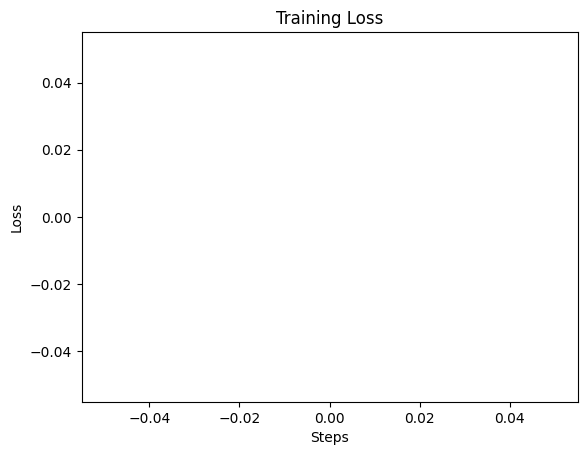


mean reward after training =  27.760814668060142


In [9]:
import matplotlib.pyplot as plt
from config import config
env = gym.make("highway-fast-v0", render_mode="rgb_array", config=config)

def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    state, _ = env.reset()
    losses = []
    for ep in range(N_episodes):
        print(f"ep = {ep}")
        done = False
        state, _ = env.reset()
        while not done: 
            action = agent.get_action(state)

            next_state, reward, terminated, truncated, _ = env.step(action)
            #print("ligne avant update")
            loss_val = agent.update(state, action, reward, terminated, next_state)
            #print("ligne apres update")
            state = next_state
            losses.append(loss_val)

            done = terminated or truncated
            total_time += 1

        if ((ep+1)% eval_every == 0):
            #print("Eval agent")
            rewards = eval_agent(agent, env)
            #print("episode =", ep+1, ", reward = ", np.mean(rewards))
            if np.mean(rewards) >= reward_threshold:
                break

    return losses

# Initialisation de l'environnement
env = gym.make('highway-v0')
env.reset()

# Initialisation de l'agent
action_space = env.action_space
observation_space = env.observation_space

gamma = 0.99
batch_size = 128
buffer_capacity = 10_000
update_target_every = 8

epsilon_start = 0.9
decrease_epsilon_factor = 1000
epsilon_min = 0.05

learning_rate = 1e-1

arguments = (env,
            action_space,
            observation_space,
            gamma,
            batch_size,
            buffer_capacity,
            update_target_every, 
            epsilon_start, 
            decrease_epsilon_factor, 
            epsilon_min,
            learning_rate,
        )

N_episodes = 300

agent = DQN(*arguments)

# Exécution de l'apprentissage
losses = train(env, agent, N_episodes)

# Affichage des résultats
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Évaluation de la politique finale
rewards = eval_agent(agent, env, 20)
print("")
print("mean reward after training = ", np.mean(rewards))


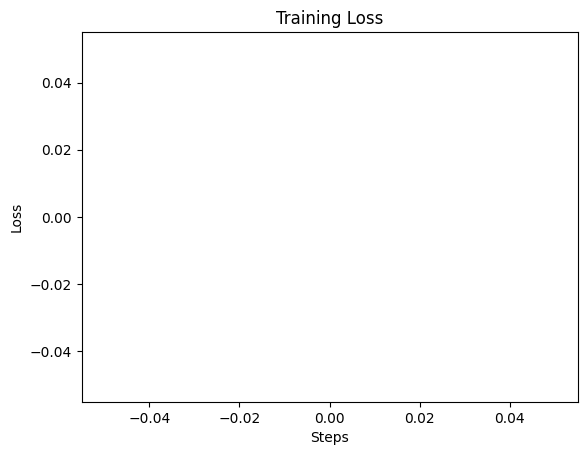

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,


In [11]:
# Affichage des résultats
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

losses

In [12]:
def visualize_agent_performance(env, agent, delay=0.1):
    """
    Visualizes the agent's performance in the environment.

    :param env: The gym environment.
    :param agent: The trained agent.
    :param delay: Time delay between frames in seconds for better visualization.
    """
    # Reset the environment and get the initial state
    state, _ = env.reset()

    # Initialize done flag
    done = False

    # Loop until the episode is finished
    while True:
        done = truncated = False
        obs, info = env.reset()
        while not (done or truncated):
            action = agent.get_action(state, 0)
            obs, reward, done, truncated, info = env.step(action)
            env.render()


In [13]:
%matplotlib inline
visualize_agent_performance(env, agent)

c:\Users\louis\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\highway_env\envs\common\abstract.py:276: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("highway-v0", render_mode="rgb_array")
  gym.logger.warn(
c:\Users\louis\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\highway_env\envs\common\abstract.py:276: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("highway-v0", render_mode="rgb_array")
  gym.logger.warn(
c:\Users\louis\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\highway_env\envs\common\abstract.py:276: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("highway-v0", render_mode="rgb_array")
  gym.logger.warn(
c:\Users\louis\.pyenv\pyenv-win\versions\3.8.10\lib\sit

KeyboardInterrupt: 